# Goal Programming methodology 



In [1]:
from mip import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

Using Python-MIP package version 1.6.2


## Input

The input of this method includes the following variables:

* numSecurities (integer) is the number of securities, <br>
* companyName (str list) contains the names of the securities, <br>
* betaIndex (float list) contains the beta index for each security, <br>
* DYIndex (float list) contains the dividend yield for each security.

In [2]:
numSecurities = 6
companyName = ['ACN', 'NOC', 'IBM', 'MSI', 'MSCI', 'ORA']
betaIndex = [0.8, 1.36, 0.59, 1.12, 1.05, 1.15]
Rev = [32.89, 77.86, 7.63, 1.48, 43.22, 39.53]
DYIndex = [1.44, 4.59, 1.33, 1.22, 1.74, 1.76]

## Model Parameters

The parameters of the model are defined below:

* numPortfolios : Number of portfolios to be constructed. <br>
* minSecurities : Minimum number of securities to participate in each portfolio. <br> 
* maxSecurities : Maximum number of securities to participate in each portfolio. <br>
* lowerBound : Minimum value of the weight of each security. <br>
* upperBound : Maximum value of the weight of each security. <br>
* capitalThreshold : Threshold that determines the Billions needed to consider a security as a high capitalisation investment

The target values of the goal programming model are set as follows:

* betaGoal : The target value for portfolio beta
* DYGoal : The target value for portfolio Dividend Yield
* highCapGoal : The target value for the percentage of high capitalisation securities participating in the portfolio

In [3]:
minSecurities = 5
maxSecurities = 6
lowerBound = 0.1
upperBound = 0.5
betaGoal = 0.8
DYGoal = 1.7
highCapGoal = 0.5
capitalThreshold = 40

The model is constructed below:

=================  Model output  ================= 
Solution status :  OptimizationStatus.OPTIMAL 

Objective function =  0.2268382352941175 

ACN :  0.09999999999999999
NOC :  0.1
IBM :  0.29999999999999993
MSI :  0.10000000000000002
MSCI :  0.4000000000000001
ORA :  0.0

Portfolio beta =  0.925
Portfolio dividend yield =  1.82
High capitalisation percentage 0.5000000000000001


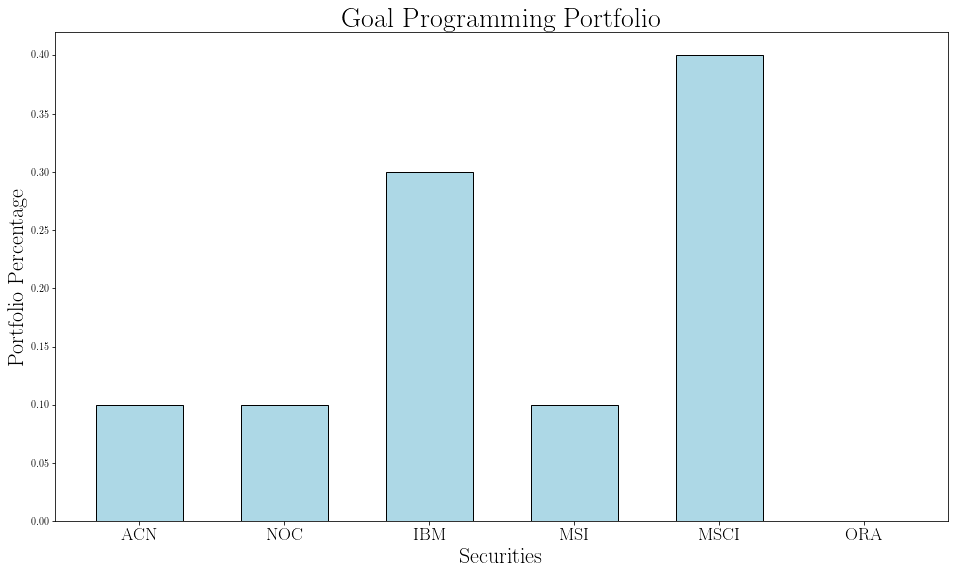

In [4]:
m = Model()

high = [0 for i in range(numSecurities)]
for i in range(numSecurities):
    if Rev[i] > capitalThreshold:
        high[i] =1

onoff = [ m.add_var(var_type=BINARY) for i in range(numSecurities) ]
weights = [ m.add_var(var_type=CONTINUOUS) for i in range(numSecurities) ]

d1P = m.add_var(var_type=CONTINUOUS)
d1M = m.add_var(var_type=CONTINUOUS)
d2P = m.add_var(var_type=CONTINUOUS)
d2M = m.add_var(var_type=CONTINUOUS)
d3P = m.add_var(var_type=CONTINUOUS)
d3M = m.add_var(var_type=CONTINUOUS)

w1P = 1
w1M = 1
w2P = 1
w2M = 1
w3P = 1
w3M = 1

m += xsum(weights[i] for i in range(numSecurities)) == 1
m += xsum(onoff[i] for i in range(numSecurities)) <= maxSecurities
m += xsum(onoff[i] for i in range(numSecurities)) >= minSecurities
for i in range(numSecurities):
    m += weights[i] - lowerBound * onoff[i] >= 0
    m += weights[i] - upperBound * onoff[i] <= 0 

m += xsum(weights[i] * betaIndex[i] for i in range(numSecurities)) + d1M - d1P == betaGoal
m += xsum(weights[i] * DYIndex[i] for i in range(numSecurities)) + d2M - d2P == DYGoal
m += xsum(weights[i] * high[i] for i in range(numSecurities)) + d3M - d3P == highCapGoal

m.objective = minimize((w1P * d1P + w1M * d1M) / betaGoal + (w2P * d2P + w2M * d2M) / DYGoal + (w3P * d3P + w3M * d3M) / highCapGoal) 

status = m.optimize()

print("=================  Model output  ================= ")

print("Solution status : ", status, "\n")
obj = m.objective_value
print("Objective function = ", obj, "\n")


for i in range(numSecurities):
    print(companyName[i],": ", weights[i].x * onoff[i].x)
print()


print("Portfolio beta = ", sum(weights[i].x * betaIndex[i] for i in range(numSecurities)))
print("Portfolio dividend yield = ", sum(weights[i].x * DYIndex[i] for i in range(numSecurities)))
print("High capitalisation percentage", sum(weights[i].x * high[i] for i in range(numSecurities)))

portfolio = [0 for i in range(numSecurities)]
for i in range(numSecurities):
    portfolio[i] = onoff[i].x * weights[i].x

plt.figure(figsize=(16,9))
plt.bar(companyName, portfolio, color = 'lightblue', edgecolor = 'black', width=0.6)
plt.xlabel(r"Securities", fontsize=22)
plt.ylabel(r"Portfolio Percentage", fontsize=22)
plt.title(r"Goal Programming Portfolio", fontsize=28)
plt.xticks(fontsize=18, rotation=0)
plt.savefig("barplot12.png", dpi=300)